# Classification with Decision Trees

## Import the libraries

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

Set the rng seed.

In [23]:
seed = 17

## Import and view data

In [24]:
df = pd.read_csv("data/train_prepd_3.csv")
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_Q,Embarked_S,Title_Miss,Title_Mr,Title_Mrs,Title_Other,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T
0,0.0,3,22.0,7.2500,1,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0
1,1.0,1,38.0,71.2833,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0
3,1.0,1,35.0,53.1000,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
4,0.0,3,35.0,8.0500,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0


dims:  (891, 20)


Decision trees do not support categorical data. Check data types.

In [25]:
df.dtypes

Survived       float64
Pclass           int64
Age            float64
Fare           float64
FamSize          int64
Sex_male         int64
Embarked_Q       int64
Embarked_S       int64
Title_Miss       int64
Title_Mr         int64
Title_Mrs        int64
Title_Other      int64
Deck_B           int64
Deck_C           int64
Deck_D           int64
Deck_E           int64
Deck_F           int64
Deck_G           int64
Deck_M           int64
Deck_T           int64
dtype: object

Split into dependent and independent variables.

In [26]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Build a preliminary classification tree

Split into train and test set. Because data are somewhat imbalanced (38% survived), we'll also use stratification.

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)

Build a basic decision tree model and predict the dependent variable for the test set.

Accuracy: 79.33 %


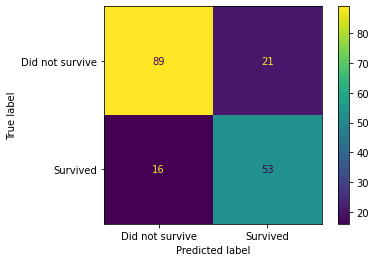

In [28]:
# Build the model shell and fit on the training set.
from sklearn.tree import DecisionTreeClassifier
clf_prel = DecisionTreeClassifier(criterion = 'gini', random_state = seed)
clf_prel.fit(X_train, y_train)

# Predict on the test set. 
y_pred = clf_prel.predict(X_test)

# Calculate accuracy and confusion matrix.
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf_prel, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

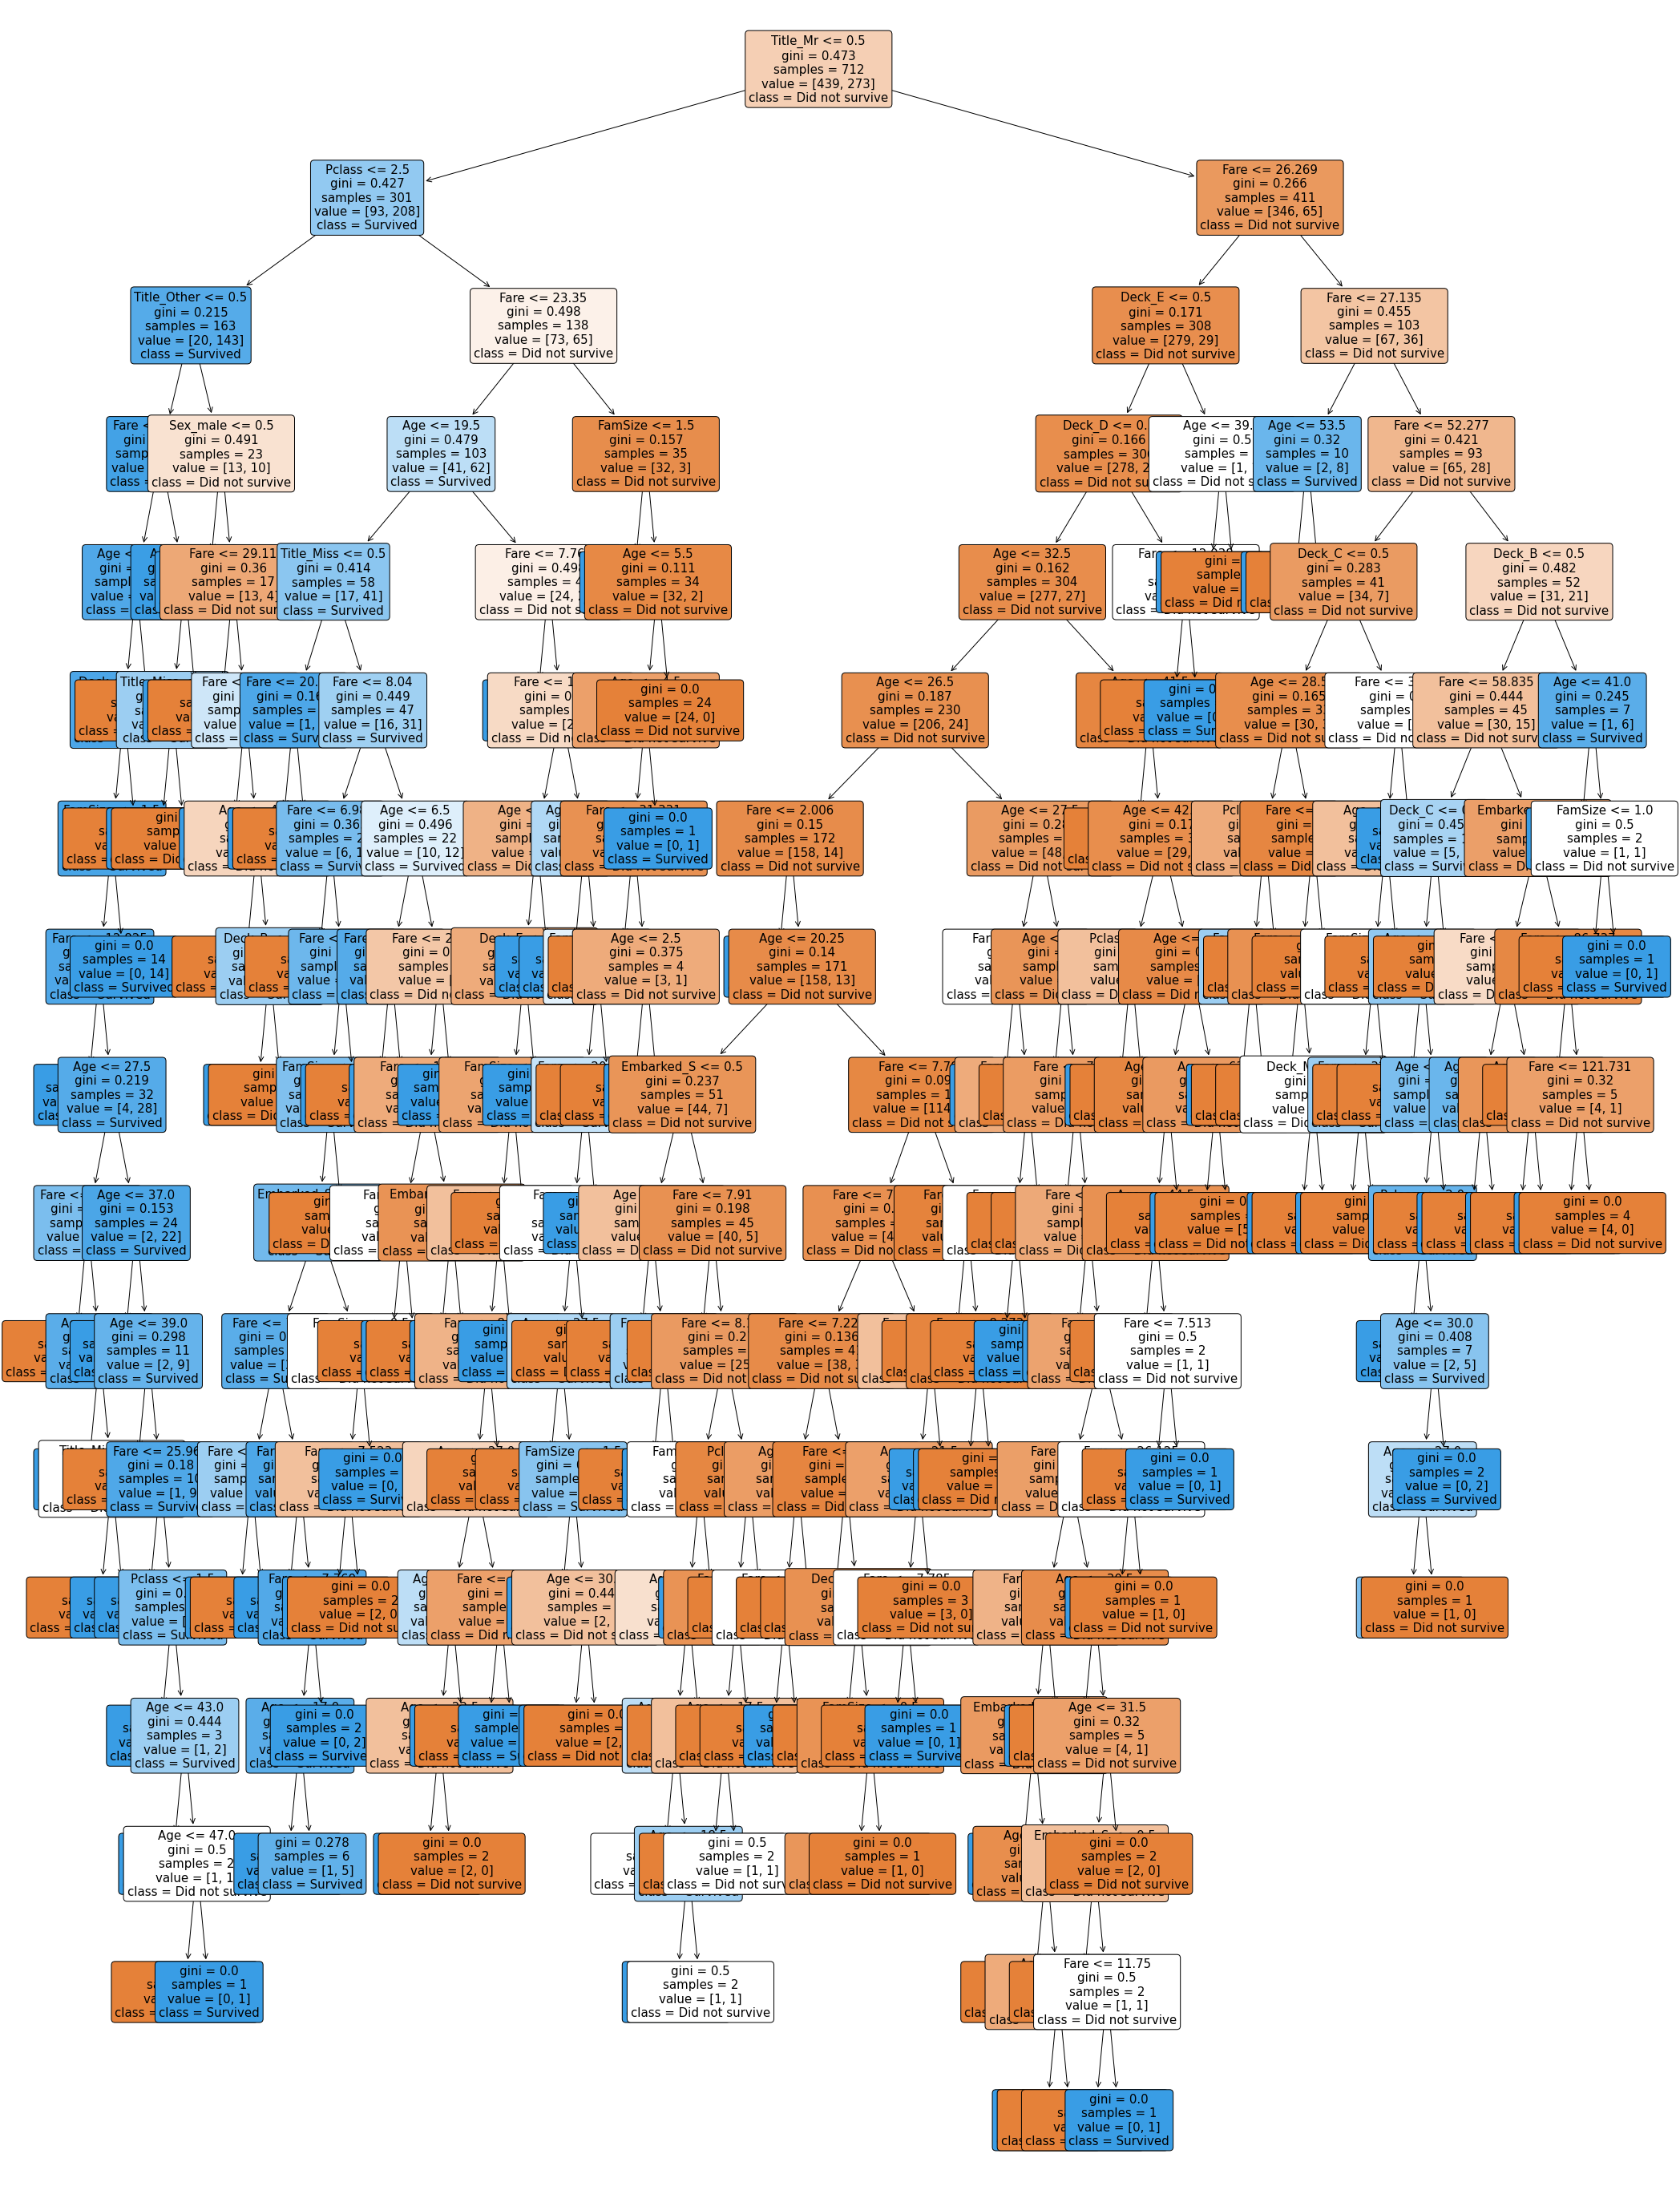

In [29]:
# Draw the decision tree.
plt.figure(figsize=(35,50))
prel_tree = tree.plot_tree(clf_prel, 
                   feature_names=pd.DataFrame(X).columns, 
                   class_names=["Did not survive", "Survived"],
                   filled=True,
                   rounded=True,
                  fontsize=15)


This is a huge tree, definitely overfitting the training data. Examine the fit on the training set.

Accuracy: 99.16 %


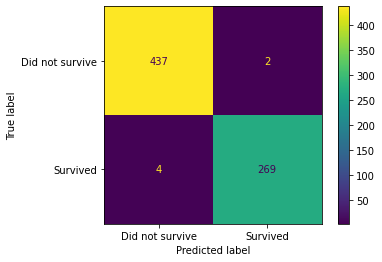

In [30]:
# Predict the dependent variable on the training set.
y_pred_tr = clf_prel.predict(X_train)

# Calculate accuracy and confusion matrix.
acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Draw the confusion matrix
plot_confusion_matrix(clf_prel, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Get a more robust estimate for the accuracy of the preliminary tree with 10-fold CV (repeated and stratified).

In [31]:
# Create the cv tactic.
cv_rep_str = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get CV accuracy and st dev.
scores = cross_val_score(clf_prel, X, y, scoring='accuracy', n_jobs=-1, cv=cv_rep_str)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))




scores:  [0.81111111 0.82022472 0.70786517 0.76404494 0.75280899 0.76404494
 0.85393258 0.78651685 0.85393258 0.84269663 0.78888889 0.80898876
 0.75280899 0.83146067 0.76404494 0.83146067 0.76404494 0.79775281
 0.82022472 0.73033708 0.83333333 0.76404494 0.83146067 0.80898876
 0.86516854 0.76404494 0.82022472 0.73033708 0.85393258 0.75280899
 0.82222222 0.85393258 0.7752809  0.73033708 0.73033708 0.80898876
 0.75280899 0.82022472 0.85393258 0.79775281 0.76666667 0.82022472
 0.83146067 0.75280899 0.74157303 0.82022472 0.80898876 0.79775281
 0.82022472 0.78651685]
Accuracy: 79.53 %
St.dev: 0.0402


Text(0.5, 0, 'Decision Tree Feature Importance')

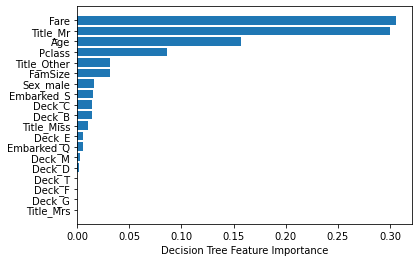

In [32]:
sorted_idx = clf_prel.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf_prel.feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")

## Hyperparameter tuning / Pruning the tree

The preliminary model is overfit on the training data. I'm going to attempt to find a smaller tree, to increase bias but lower variance. We will try Cost Complexity Pruning.

First, with a train test split.

In [33]:
# get alpha values from the full tree (train + test)
clf = DecisionTreeClassifier(criterion = 'gini', random_state = seed)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas
# omit the maximum value for alpha, as this is the trivial tree with only a root note.
ccp_alphas = ccp_alphas[:-1]

In [34]:
# now, using the train data, fit a tree on each value of alpha and store all of them in a list
dts = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=seed, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    dts.append(clf)  

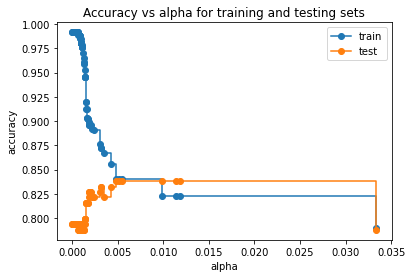

In [35]:
# get train and test scores for each tree
train_scores = [clf.score(X_train, y_train) for clf in dts]
test_scores = [clf.score(X_test, y_test) for clf in dts]


# plot accuracy vs alpha
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [36]:
# return the alpha that yields the highest accuracy for the test set
d = {'alpha': ccp_alphas, 'train': train_scores, 'test': test_scores}
df = pd.DataFrame(data=d)

print('best tree: ')
df.loc[df['test'].idxmax()]

best tree: 


alpha    0.004815
train    0.839888
test     0.837989
Name: 70, dtype: float64

Then with cross validation, because different train test splits will result in different model accuracy. 

In [37]:
dts = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=seed, ccp_alpha=alpha)
    scores = cross_val_score(clf, X, y, cv=10)
    dts.append([alpha, np.mean(scores), np.std(scores)])

In [38]:
alpha_results = pd.DataFrame(dts, columns=['alpha', 'mean', 'std'])
alpha_results.head(50)

,alpha,mean,std
0,0.000000,0.784582,0.045286
1,0.000023,0.784582,0.045286
2,0.000132,0.784582,0.045286
3,0.000187,0.784582,0.045286
4,0.000224,0.784582,0.045286
5,0.000242,0.784582,0.045286
6,0.000299,0.783471,0.046910
7,0.000343,0.783471,0.046910
8,0.000374,0.783471,0.046910
9,0.000524,0.782347,0.046144


<AxesSubplot:xlabel='alpha'>

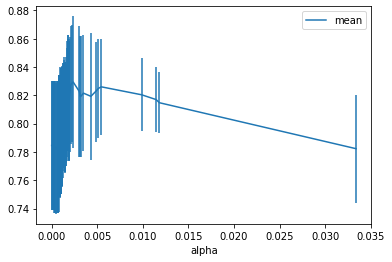

In [39]:
# plot mean accuracy and std. error for different values of alpha
alpha_results.plot(x='alpha', y='mean', yerr='std')

In [40]:
# return the alpha that yields the highest accuracy for the test set
print(alpha_results.loc[alpha_results['mean'].idxmax()])
alpha_best = alpha_results.loc[alpha_results['mean'].idxmax()][0]

alpha    0.002363
mean     0.829413
std      0.046510
Name: 64, dtype: float64


## Build the final model

Accuracy: 82.12 %


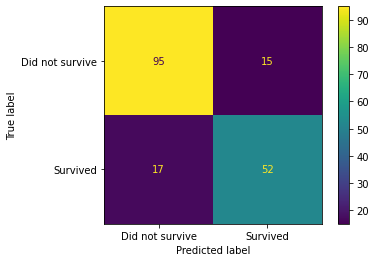

In [41]:
# Create model shell and fit on the training data.
clf = DecisionTreeClassifier(criterion = 'gini', ccp_alpha=alpha_best, random_state = seed)
clf.fit(X_train, y_train)

# Predict on the test data.
y_pred = clf.predict(X_test)

# Get accuracy and confusion matrix.
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Plot the confusion matrix.
plot_confusion_matrix(clf, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

The tree seems to be doing a good job at correctly classifying those that did not survive (Sensitivity: 87%), but does not so well at correctly classifying those that survived (Specificity: 75%).

Plot the pruned tree.

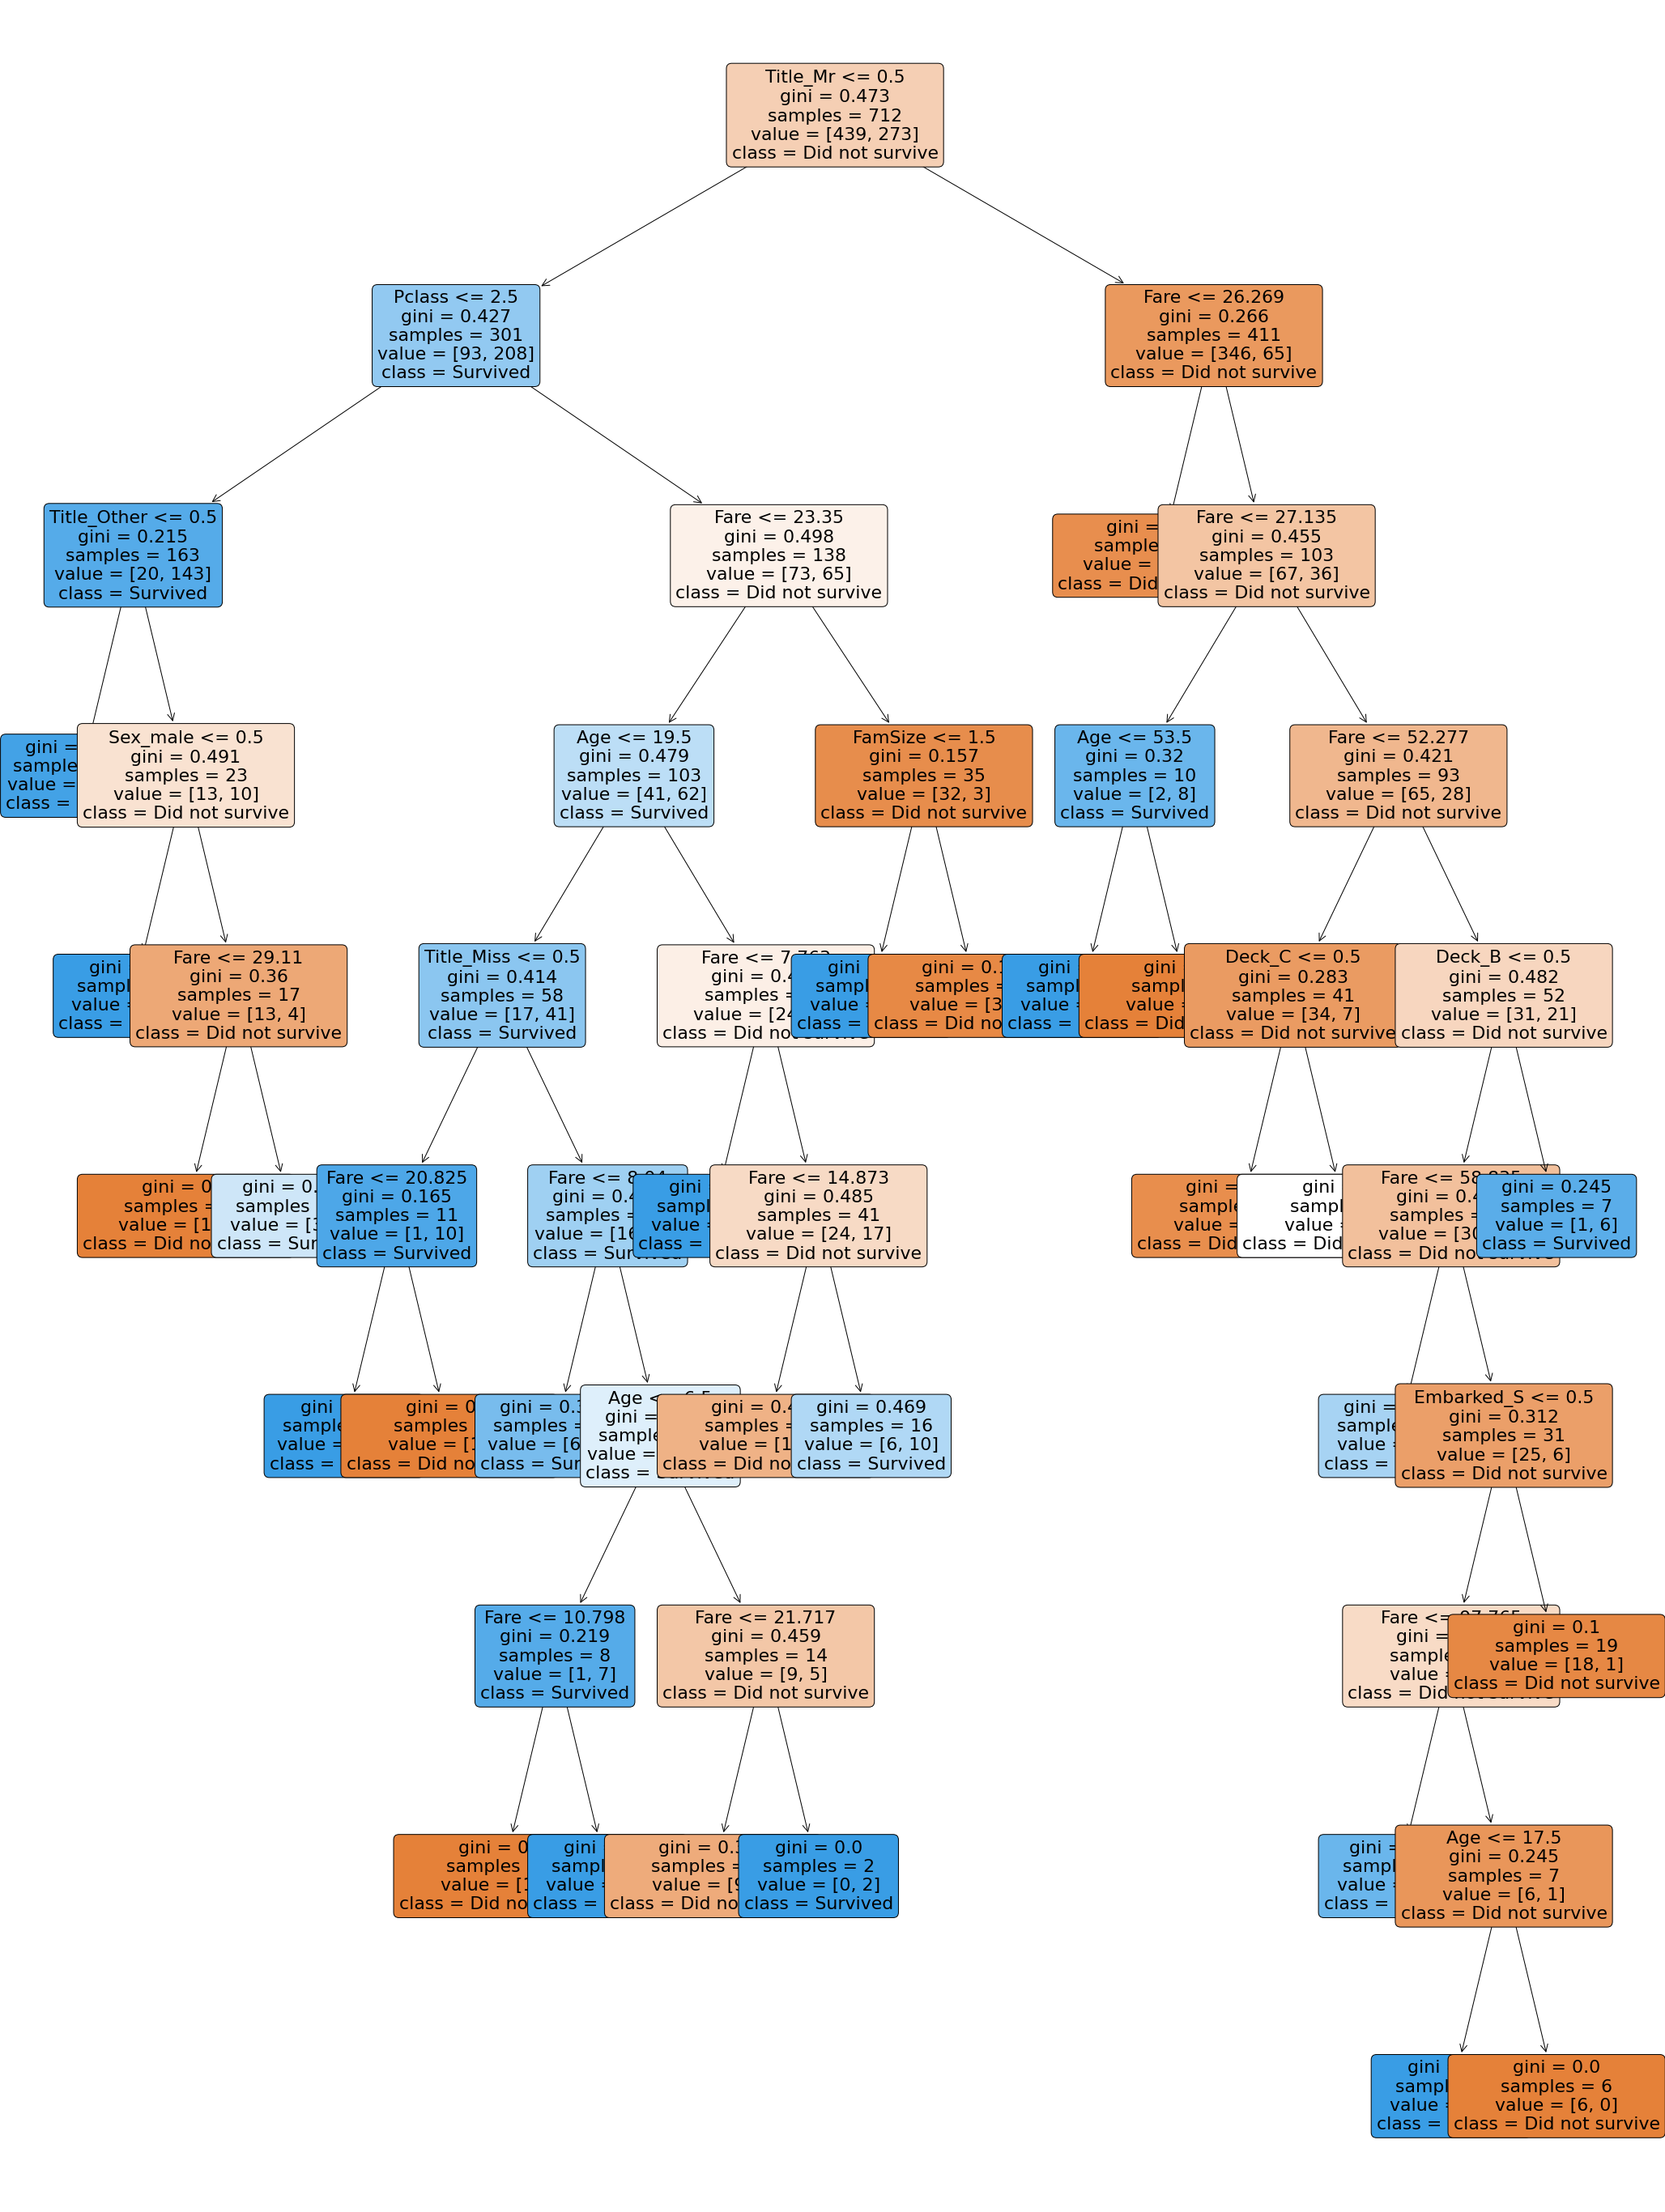

In [42]:
plt.figure(figsize=(35,50))
prel_tree = tree.plot_tree(clf, 
                   feature_names=pd.DataFrame(X).columns, 
                   class_names=["Did not survive", "Survived"],
                   filled=True,
                   rounded=True,
                  fontsize=22)

Re-assess overfitting by predicting the dependent variable on the training set.

Accuracy: 89.04 %


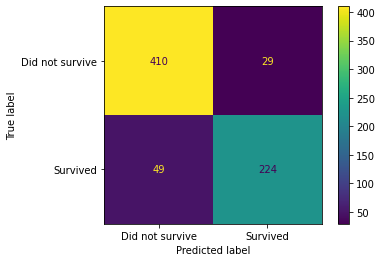

In [43]:
# Predict on the training data
y_pred_tr = clf.predict(X_train)

# Get accuracy and confusion matrix.
acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Plot the confusion matrix.
plot_confusion_matrix(clf, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Overfitting is significantly reduced.

Get a more robust estimate for the model accuracy, again using repeated and stratified 10-fold CV.

In [44]:
# Create the cv tactic.
cv_rep_str = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get CV accuracy and st dev.
scores = cross_val_score(clf, X, y, scoring='accuracy', n_jobs=-1, cv=cv_rep_str)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))


scores:  [0.85555556 0.86516854 0.76404494 0.79775281 0.79775281 0.73033708
 0.87640449 0.87640449 0.84269663 0.82022472 0.78888889 0.82022472
 0.80898876 0.84269663 0.83146067 0.78651685 0.82022472 0.86516854
 0.84269663 0.83146067 0.85555556 0.83146067 0.82022472 0.82022472
 0.84269663 0.78651685 0.86516854 0.80898876 0.79775281 0.76404494
 0.83333333 0.83146067 0.82022472 0.75280899 0.82022472 0.87640449
 0.80898876 0.79775281 0.86516854 0.79775281 0.78888889 0.82022472
 0.83146067 0.82022472 0.78651685 0.83146067 0.85393258 0.84269663
 0.78651685 0.75280899]
Accuracy: 81.95 %
St.dev: 0.0339


The final pruned tree performs about 3% better than the preliminary one (82% vs 79%)

Text(0.5, 0, 'Decision Tree Feature Importance')

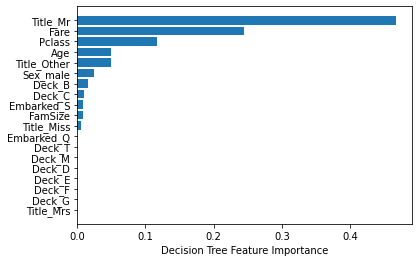

In [46]:
sorted_idx = clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], clf.feature_importances_[sorted_idx])
plt.xlabel("Decision Tree Feature Importance")